This machine learning algorithm utilizes Collaborative Filtering via Matrix Factorization to suggest songs given a playlist name. Normal matrix factorization usually relates a user and their activity with another item. In this case here, a word (playlist) is being related with a spotify track (song). So we can give the machine learning model a playlist name, and it can recommend songs which it has seen before related to that playlist name.

The dataset used here is a large list of previously made spotify playlists and their songs. You'll need to download the spotify recommendator challenge dataset from https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge and place it within the datasets/ folder for this code to work.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
from numpy import savetxt
import re
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

seed = 22
np.random.seed(seed)

auth_manager = SpotifyClientCredentials(client_id='5e87783324eb47cba39f43f39e374c71',client_secret='68427108059946e9abfa226df5780371')
sp = spotipy.Spotify(auth_manager=auth_manager)

Import data and filter out data that is not useful. Ex. playlists with no songs or no name or with no tracks

In [2]:
def encode_values(col):
    unique_items = np.unique(col)
    items_to_encoded = {x: i for i, x in enumerate(unique_items)}
    encoded_to_items = {i: x for i, x in enumerate(unique_items)}
    return (items_to_encoded, encoded_to_items)

playlist_df = pd.read_json('./datasets/challenge_set.json')
playlist_series = playlist_df['playlists']
playlist_data = []

for item in playlist_series[::10]:
    if len(item['tracks']) > 0 and 'name' in item and re.search("[a-zA-Z]+", item['name']) is not None:
        dataset = { 'name': item['name'].lower(), 'tracks': [] }
        for track in item['tracks']:
            dataset['tracks'].append(track['track_uri'].split(':')[2])
        playlist_data.append(dataset)

This code converts the data into a numeric encoded dataset which is more friendlier for machine learning.

In [3]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def encode_values(col):
    unique_items = np.unique(col)
    items_to_encoded = {x: i for i, x in enumerate(unique_items)}
    encoded_to_items = {i: x for i, x in enumerate(unique_items)}
    return (items_to_encoded, encoded_to_items)

playlists = [playlist['name'].split(' ') for playlist in playlist_data]
playlists = pd.Series(np.unique(flatten(playlists)))
playlist_items_to_encoded, playlist_encoded_to_items = encode_values(playlists)
encoded_playlists = playlists.map(playlist_items_to_encoded)

tracks = [playlist['tracks'] for playlist in playlist_data]
tracks = pd.Series(np.unique(flatten(tracks)))
track_id_items_to_encoded, track_id_encoded_to_items = encode_values(tracks)
encoded_tracks = tracks.map(track_id_items_to_encoded)

playlists.describe()
tracks.describe()

count                      13811
unique                     13811
top       000xQL6tZNLJzIrtIgxqSl
freq                           1
dtype: object

This code builds a histogram of which songs are in which playlist word. This is used to generate the training and test dataset.

In [4]:
playlist_histogram = {playlist_id: [] for playlist_id in encoded_playlists}

for playlist in playlist_data:
    for name in playlist['name'].lower().split(' '):
        for track in playlist['tracks']:
            playlist_histogram[playlist_items_to_encoded[name]].append(track_id_items_to_encoded[track])

x = np.empty((len(playlists) * len(tracks), 2), np.uintc)
y = np.zeros(len(playlists) * len(tracks), np.byte)

for playlist_id, histogram_track_ids in playlist_histogram.items():
    # iterate though histogram
    for track_id in histogram_track_ids:
        index = playlist_id * len(playlists) + track_id
        y[index] = 1

    # iterate through all tracks
    for track_id in encoded_tracks:
        index = playlist_id * len(playlists) + track_id
        x[index][0] = playlist_id
        x[index][1] = track_id

array_shuffle = np.arange(len(x))
np.random.shuffle(array_shuffle)

x = np.array(x)[array_shuffle]
y = np.array(y)[array_shuffle]

print(x.shape)
print(y.shape)

train_indices = int(0.9 * len(x))
x_train = x[:train_indices]
y_train = y[:train_indices]
x_test = x[train_indices:]
y_test = y[train_indices:]

(6449737, 2)
(6449737,)


Matrix Factorization machine learning algorithm which utilizes Embedding layers to approximate the original feedback matrix A. A low learning rate was used here due to the large dataset and batch size. A default size of 400 is used for the embedding layers.

In [5]:
class TrackRecommender(keras.Model):
    def __init__(self, playlist_count, track_count, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.playlist_embedding = keras.layers.Embedding(
            playlist_count,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.playlist_bias = keras.layers.Embedding(playlist_count, 1)
        self.track_embedding = keras.layers.Embedding(
            track_count,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.track_bias = keras.layers.Embedding(track_count, 1)

    def call(self, inputs):
        playlist_vector = self.playlist_embedding(inputs[:, 0])
        playlist_bias = self.playlist_bias(inputs[:, 0])
        track_vector = self.track_embedding(inputs[:, 1])
        track_bias = self.track_bias(inputs[:, 1])
        
        dot = tf.tensordot(playlist_vector, track_vector, 2)
        x = dot + playlist_bias + track_bias
        return tf.nn.sigmoid(x)

model = TrackRecommender(len(playlists), len(tracks), 400)
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

In [6]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=100000,
    epochs=10,
    verbose=1,
    validation_data=(x_test, y_test),
)

Epoch 1/10
59/59 [==============================] - 15s 245ms/step - loss: 2088.2273 - accuracy: 0.0050 - val_loss: 1324.6385 - val_accuracy: 0.0051
Epoch 2/10
59/59 [==============================] - 14s 240ms/step - loss: 673.4083 - accuracy: 0.0399 - val_loss: 0.3596 - val_accuracy: 0.9949
Epoch 3/10
59/59 [==============================] - 14s 242ms/step - loss: 1.0923 - accuracy: 0.9950 - val_loss: 1.1825 - val_accuracy: 0.9949
Epoch 4/10
59/59 [==============================] - 14s 239ms/step - loss: 1.1966 - accuracy: 0.9950 - val_loss: 1.1410 - val_accuracy: 0.9949
Epoch 5/10
59/59 [==============================] - 14s 241ms/step - loss: 1.1583 - accuracy: 0.9950 - val_loss: 1.1000 - val_accuracy: 0.9949
Epoch 6/10
59/59 [==============================] - 14s 239ms/step - loss: 1.1047 - accuracy: 0.9950 - val_loss: 1.0369 - val_accuracy: 0.9949
Epoch 7/10
59/59 [==============================] - 14s 239ms/step - loss: 1.0382 - accuracy: 0.9950 - val_loss: 0.9629 - val_accuracy

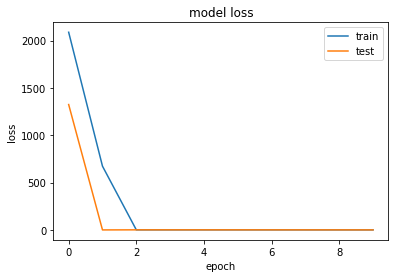

In [7]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"])
plt.show()

Utilize the model and the Spotify API to see the songs that are recommended. The 5 highest songs are recommended.

In [31]:
# choose a playlist name here
playlist_name = 'pop love'
# names to use: 'country rock', 'pop love'

def predict(word):
    playlist_id = playlist_items_to_encoded[word]

    input1 = [[item] for item in np.repeat(playlist_id, len(tracks))]
    input2 = [[item] for item in list(track_id_encoded_to_items.keys())]
    input_matrix = np.hstack((input1, input2))

    return np.array(model.predict(input_matrix).flatten())

print('Selected playlist name: ' + playlist_name)
playlist_name = playlist_name.lower()

print('Running recommendation:')
valid_words = [name for name in playlist_name.split(' ') if name in playlist_items_to_encoded]

if (len(valid_words) == 0):
    raise ValueError('No searchable playlist keywords found.')

prediction_list = [predict(word) for word in valid_words]
prediction = np.prod(np.vstack(prediction_list), axis=0)

recommended_indices = np.argsort(prediction)[::-1][:5]
recommended_tracks = [sp.track(track_id_encoded_to_items[index]) for index in recommended_indices]

prediction.sort()
prediction_values = prediction[::-1][:5]
print('Recommended Songs:')
for index, track in enumerate(recommended_tracks):
    #print(track)
    print('Track: ' + track['name'] + ' [' + track['id'] + ']')
    print('Recommendation Strength: ' + str(prediction_values[index]))
    artists = sp.artists([artist['id'] for artist in track['artists']])['artists']
    artist_names = [artist['name'] for artist in artists]
    artist_genres = np.unique(flatten([artist['genres'] for artist in artists]))
    print('Artists: ' + str.join(', ', artist_names))
    print('Genres: ' + str.join(', ', artist_genres))
    print('----')


Selected playlist name: pop love
Running recommendation:
432/432 [==============================] - 0s 603us/step
Recommended Songs:
Track: Panda [112lQZi5e7i8ohZ4z0e6nu]
Recommendation Strength: 0.3170314
Artists: Desiigner
Genres: pop rap, rap, southern hip hop, trap, viral trap
----
Track: Love and Memories [4P8R77nB50xhmP0lyQXcoJ]
Recommendation Strength: 0.3166412
Artists: O.A.R.
Genres: neo mellow, pop rock
----
Track: OMG [4Ow5x7P5NAAR1jPoskudoA]
Recommendation Strength: 0.31626973
Artists: USHER, will.i.am
Genres: atl hip hop, contemporary r&b, dance pop, pop, r&b, rap, south carolina hip hop, urban contemporary
----
Track: Come As You Are [4P5KoWXOxwuobLmHXLMobV]
Recommendation Strength: 0.31560233
Artists: Nirvana
Genres: grunge, permanent wave, rock
----
Track: Chasing Cars [11bD1JtSjlIgKgZG2134DZ]
Recommendation Strength: 0.31534985
Artists: Snow Patrol
Genres: irish rock, modern rock, neo mellow, permanent wave, pop rock
----
